# Prediction using Spectral Transformations

### Packages

In [1]:
# os libraries
import os

In [2]:
# numerical libraries
import numpy as np
import pandas as pd

In [3]:
# visualization libraries
import matplotlib.pyplot as plt

In [4]:
# statistical learning libraries
import sklearn.preprocessing as pr
import sklearn.linear_model as lm

### Functions

In [6]:
def MSE(model, X, y):
    '''
    Get MSE of model on test data.
    
    Arguments:
        model: prediction model
        
    Returns:
        score: MSE loss
    '''
    
    # compute number of points in data
    n = y.shape[0]
    
    # return loss
    return (1/n) * np.sum(np.square(model.predict(X) - y))

In [7]:
def export_results(model, X):
    '''
    Export results into CSV file for submission.
    
    Arguments:
        model: regression model
    '''
    
    # obtain predictions
    pred = model.predict(X)
    
    # obtain index of data
    idx = X.index
    
    # set in dataframe
    df_results = pd.DataFrame({'_ID': idx, '0': pred})
    
    # save dataframe
    df_results.to_csv('submissions/submit.csv', sep=',', index=False, index_label='_ID')

### Data Loading

In [8]:
# read X_train
df_X_train = pd.read_csv('data/input_training.csv', sep=',', header=0, index_col=0)
X_train = df_X_train.values

In [9]:
# read y_train
df_y_train = pd.read_csv('data/output_training.csv', sep=',', header=0, index_col=0)
y_train = df_y_train.values.ravel()

In [10]:
# read X_test
df_X_test = pd.read_csv('data/input_testing.csv', sep=',', header=0, index_col=0)
X_test = df_X_test.values

### Data Normalisation

In [11]:
# concatenate train and test datasets
df = pd.concat([df_X_train, df_X_test])

In [12]:
# compute SVD decomposition
U, D, V = np.linalg.svd(df.values, full_matrices=False)

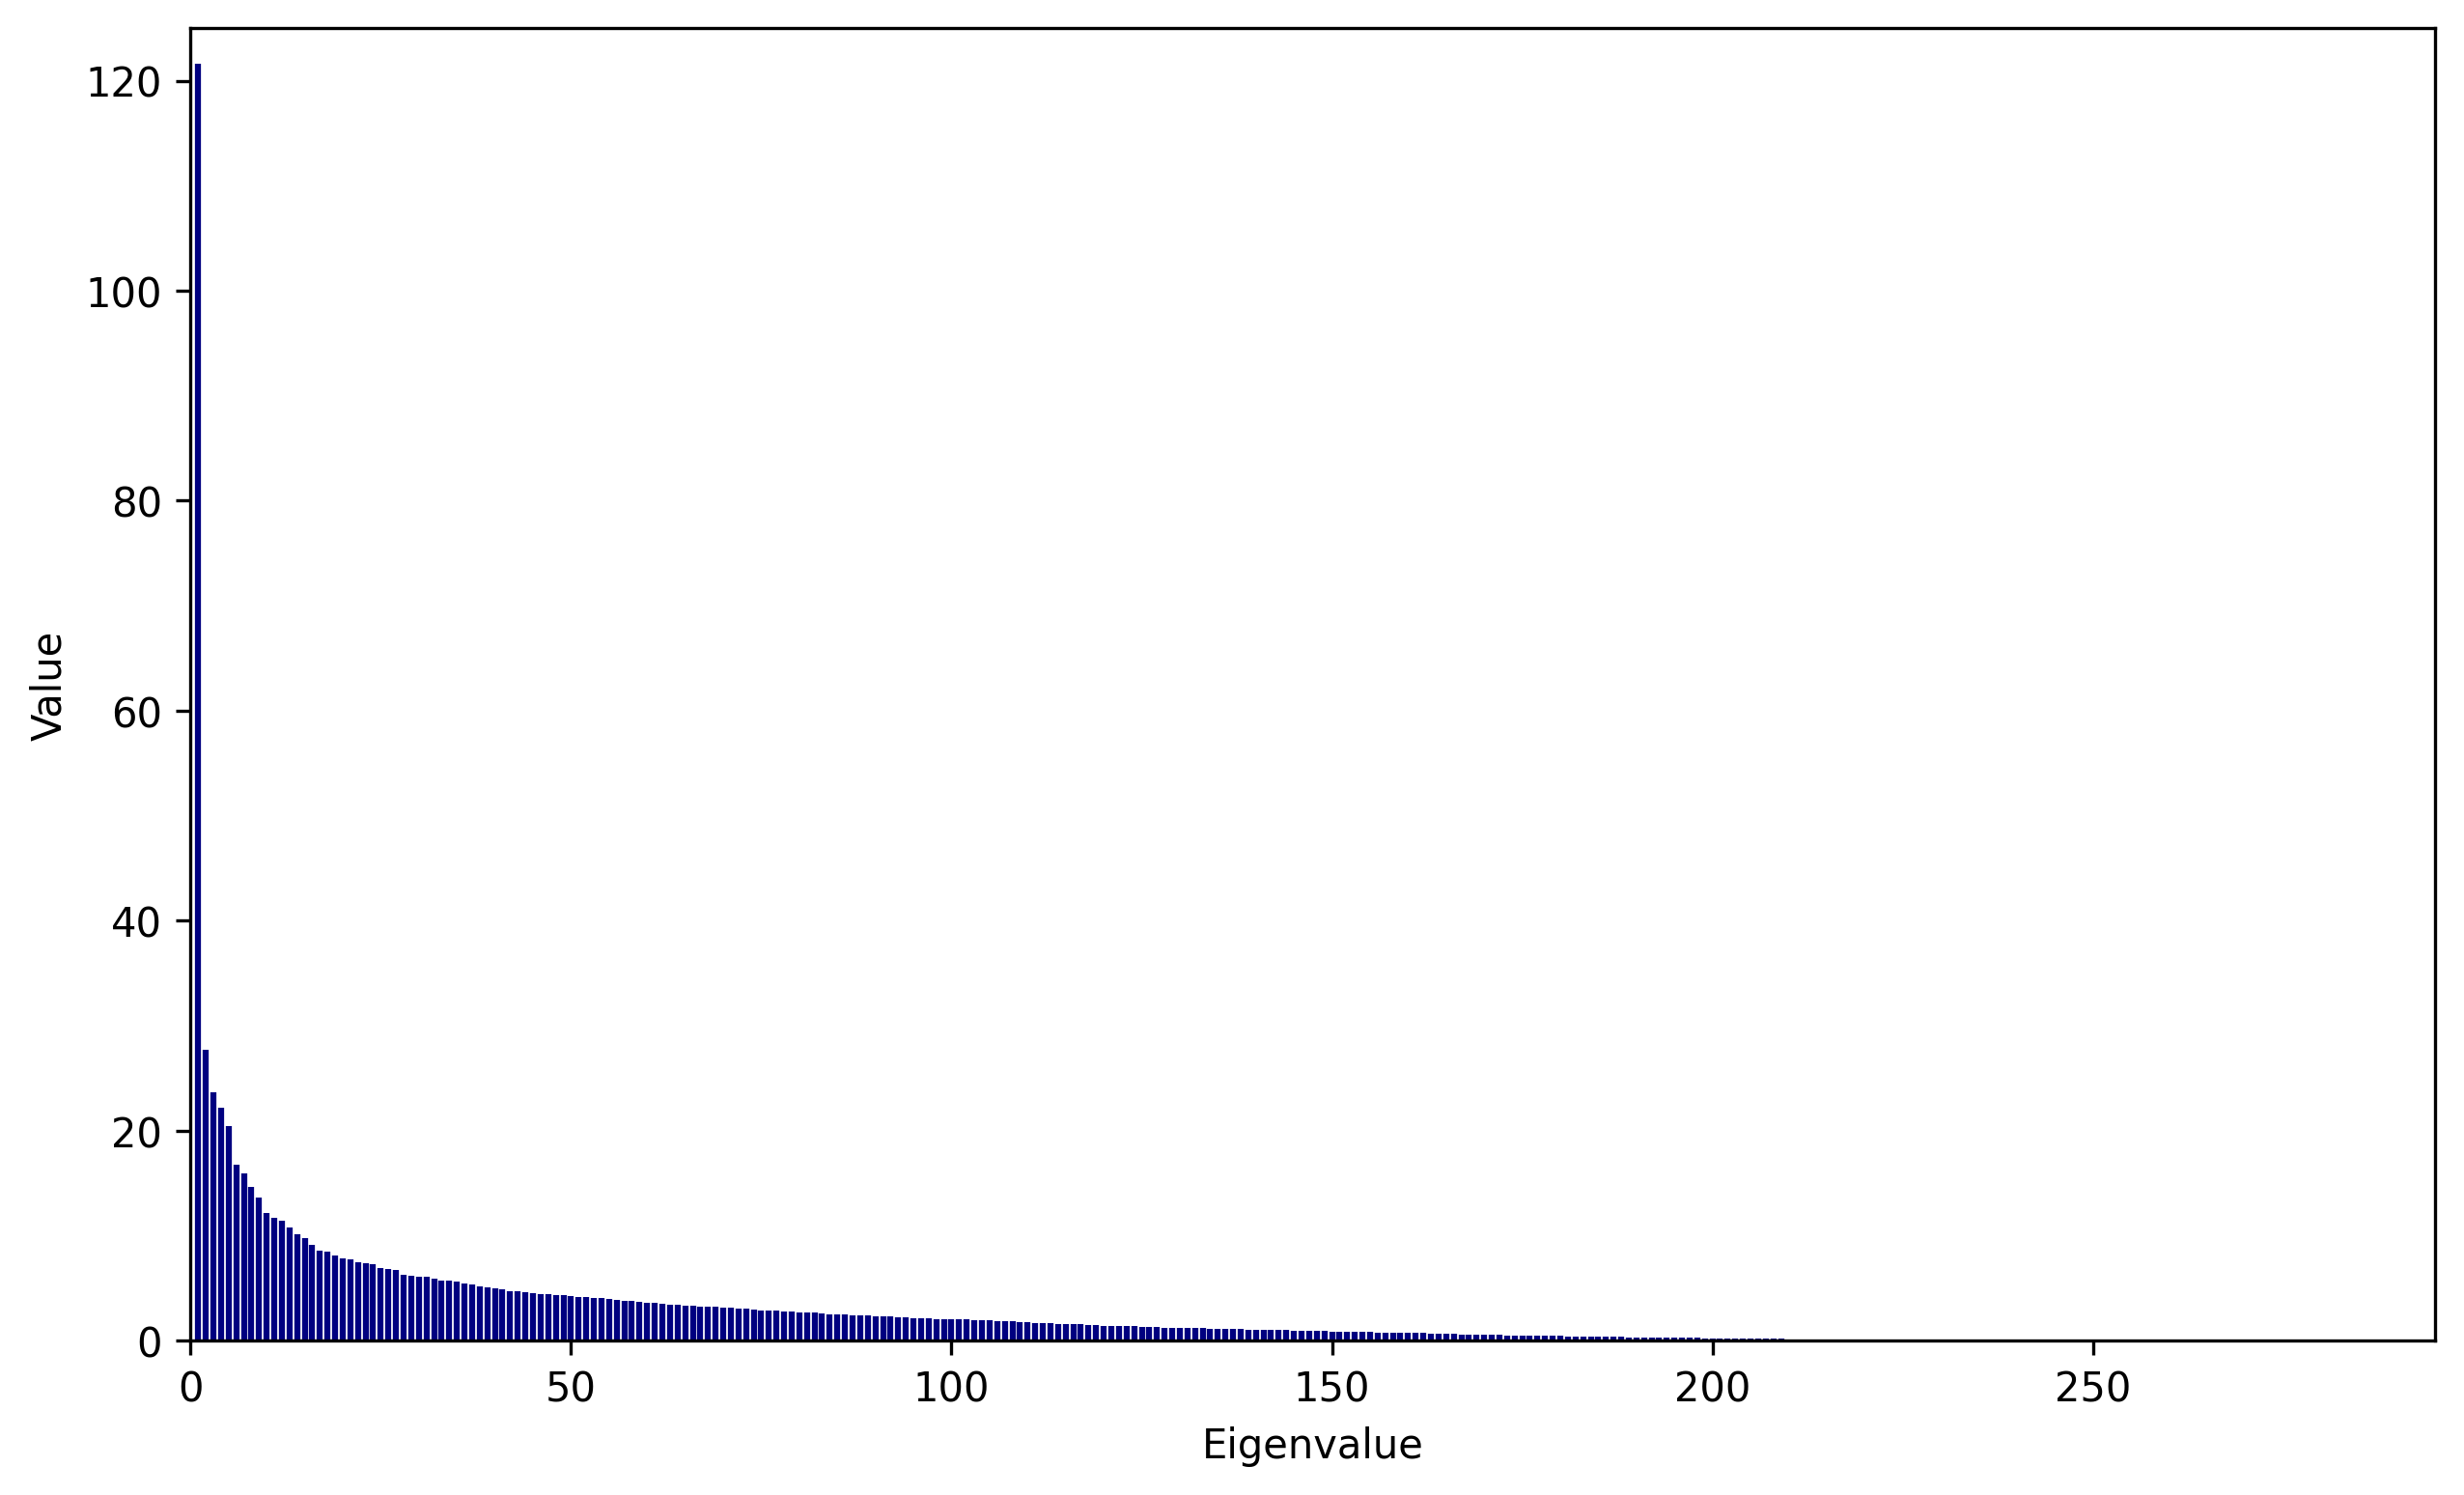

In [13]:
# plot eigenvalues
plt.figure(figsize=(10, 6), dpi=300)
plt.xlabel('Eigenvalue')
plt.ylabel('Value')
plt.axis([0, 295, 0, 125])
plt.vlines(range(1, len(D)+1), np.zeros(len(D)), np.sort(D)[::-1], colors="navy")
plt.show()

In [14]:
# compute spectral transformation
D_median = np.median(D)
F = np.linalg.multi_dot([U, np.diag([np.min([D_median, x]) / x for x in D]), U.T])

In [15]:
# compute transformed design matrix
TX = np.dot(F, df.values)

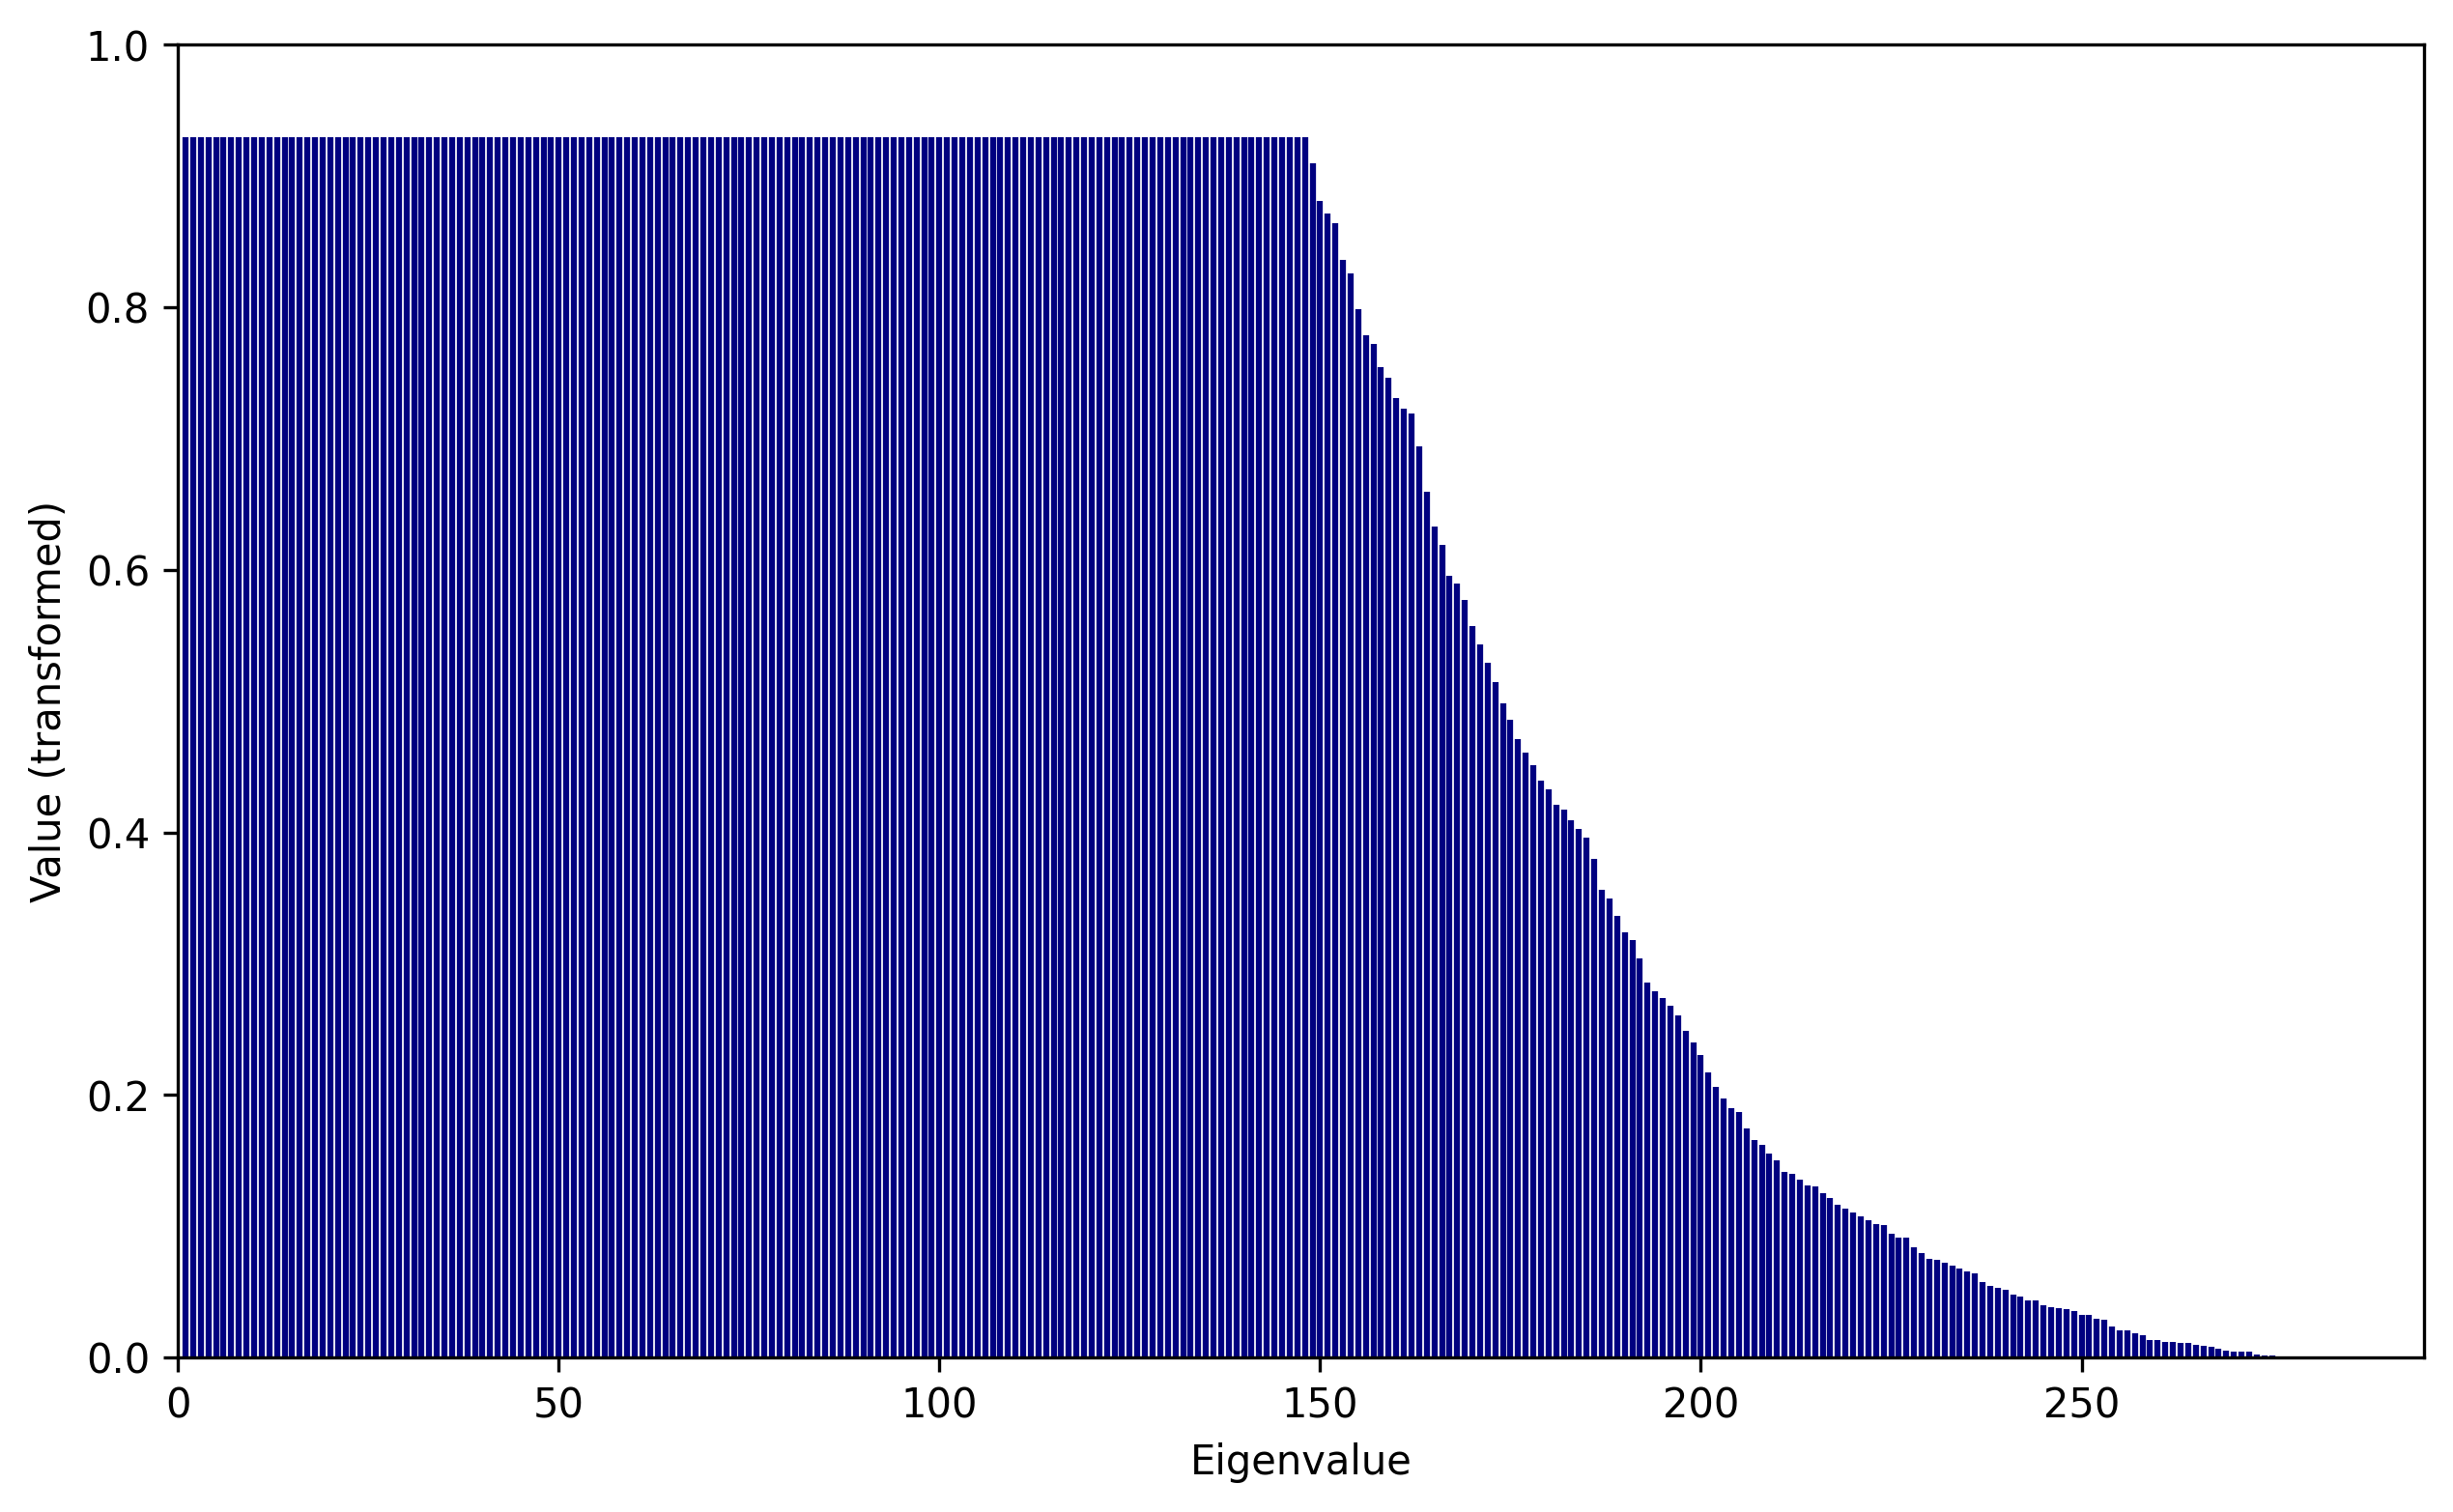

In [16]:
# compute transformed eigenvalues
TD = np.linalg.svd(TX, full_matrices=False, compute_uv=False)

# plot transformed eigenvalues
plt.figure(figsize=(10, 6), dpi=300)
plt.xlabel('Eigenvalue')
plt.ylabel('Value (transformed)')
plt.axis([0, 295, 0, 1])
plt.vlines(range(1, len(TD)+1), np.zeros(len(TD)), np.sort(TD)[::-1], colors="navy")
plt.show()

In [17]:
df = pd.DataFrame(TX, index=df.index, columns=df.columns)

### Creation of the transformed design matrices

In [18]:
# truncate to retrieve df_X_train
df_X_train_sp = df.truncate(before=None, after=df_X_train.shape[0])
X_train_sp = df_X_train_sp.values

# truncate to retrieve df_X_test
df_X_test_sp = df.truncate(before=df_X_train.shape[0]+1, after=None)
X_test_sp = df_X_test_sp.values

### Creation of the transformed outcomes

In [22]:
# create unknown y_test and append it to y_train
y_test = np.zeros(X_test_sp.shape[0])
y = np.concatenate([y_train, y_test])

# concatenate train and test outcomes
y_train_sp = np.dot(F, y)[:y_train.shape[0]]

[-0.06687781 -0.14720162  0.20511959 ... -0.24549853 -0.11802577
 -0.01104167]


### Creation of the inverse transform

In [24]:
# compute inverse of F
FI = np.linalg.inv(F)

### Ridge regression with transformed design matrix and cross-validation

In [25]:
# compute LASSO CV on augmented data
model = lm.RidgeCV(alphas=np.arange(0.01, 5+0.01, 0.01), cv=5).fit(X_train_sp, y_train_sp)

In [31]:
# predict values for train and test dataset
y_pred_sp = model.predict(np.concatenate([X_train_sp, X_test_sp]))

# apply inverse of F
y_pred = y_pred_sp

# separate train and test predictions
y_train_pred = y_pred[:y_train.shape[0]]
y_test_pred = y_pred[y_train.shape[0]+1:]

In [32]:
# print score over training dataset
print('Ridge CV score (train):', np.mean(np.square(y_train_pred - y_train)))

Ridge CV score (train): 0.08071200280156676
